# Lab 1: Data Cleaning Pipeline - From Messy to Ready!

## Welcome to Real-World Data Cleaning!

This is where you'll learn to handle the messy reality of real data - missing values, outliers, duplicates, and more!

### What You'll Build:
A complete **data cleaning pipeline** for a customer churn dataset with deliberate quality issues!

### Learning Goals:
- Identify and analyze missing data patterns
- Apply different imputation strategies
- Detect and handle outliers
- Remove duplicates
- Build an automated cleaning pipeline
- Compare cleaning strategies

### Don't Panic!
- Read each instruction carefully
- Try the TODO exercises yourself first
- Hints are provided if you get stuck
- Solutions are at the end (but try not to peek!)

**Let's clean some data!**

## Step 1: Import Libraries

First, let's import the tools we need for data cleaning.

In [10]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from scipy import stats

# Make plots look nice
plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)

print("Libraries imported successfully!")
print("You're ready to clean some messy data!")

Libraries imported successfully!
You're ready to clean some messy data!


## Step 2: Create a Messy Dataset

We'll create a **deliberately messy** customer churn dataset with:
- Missing values (MCAR, MAR, MNAR)
- Outliers in several columns
- Duplicate rows
- Mixed data types

This simulates real-world data you'll encounter!

In [11]:
# Create a messy customer churn dataset
np.random.seed(42)
n_customers = 500

# Create clean base data
data = {
    'customer_id': range(1, n_customers + 1),
    'age': np.random.normal(45, 15, n_customers).clip(18, 85).astype(int),
    'tenure_months': np.random.normal(24, 12, n_customers).clip(0, 72).astype(int),
    'monthly_charges': np.random.normal(65, 25, n_customers).clip(20, 150),
    'total_charges': np.random.normal(1500, 800, n_customers).clip(20, 6000),
    'contract_type': np.random.choice(['Month-to-month', 'One year', 'Two year'], n_customers, p=[0.5, 0.3, 0.2]),
    'payment_method': np.random.choice(['Credit card', 'Bank transfer', 'Electronic check', 'Mailed check'], n_customers),
    'internet_service': np.random.choice(['DSL', 'Fiber optic', 'No'], n_customers, p=[0.4, 0.4, 0.2]),
    'tech_support': np.random.choice(['Yes', 'No', 'No internet service'], n_customers),
    'num_support_calls': np.random.poisson(2, n_customers),
    'satisfaction_score': np.random.uniform(1, 5, n_customers),
}

# Generate churn based on features
churn_prob = (
    0.1 +  # base probability
    0.3 * (data['contract_type'] == 'Month-to-month') +
    0.2 * (data['tenure_months'] < 12) +
    0.15 * (data['num_support_calls'] > 3) +
    0.15 * (data['satisfaction_score'] < 2.5)
)
data['churn'] = (np.random.random(n_customers) < churn_prob).astype(int)

df_clean = pd.DataFrame(data)

# Now make it messy!
df = df_clean.copy()

# 1. Introduce missing values (MCAR - Missing Completely At Random)
missing_mcar_idx = np.random.choice(df.index, size=40, replace=False)
df.loc[missing_mcar_idx, 'age'] = np.nan

# 2. Introduce missing values (MAR - Missing At Random)
# Higher churn customers less likely to report satisfaction
mar_idx = df[df['churn'] == 1].sample(n=50, random_state=42).index
df.loc[mar_idx, 'satisfaction_score'] = np.nan

# 3. Introduce missing values (MNAR - Missing Not At Random)
# Customers with high charges less likely to report
mnar_idx = df[df['monthly_charges'] > 100].sample(n=35, random_state=42).index
df.loc[mnar_idx, 'monthly_charges'] = np.nan

# 4. More random missing in other columns
df.loc[np.random.choice(df.index, 30), 'tenure_months'] = np.nan
df.loc[np.random.choice(df.index, 25), 'total_charges'] = np.nan

# 5. Add outliers
outlier_idx = np.random.choice(df.index, 15, replace=False)
df.loc[outlier_idx, 'monthly_charges'] = df.loc[outlier_idx, 'monthly_charges'] * 3

outlier_idx2 = np.random.choice(df.index, 10, replace=False)
df.loc[outlier_idx2, 'num_support_calls'] = np.random.randint(15, 30, 10)

# 6. Add duplicate rows
duplicate_rows = df.sample(n=20, random_state=42)
df = pd.concat([df, duplicate_rows], ignore_index=True)

# 7. Shuffle
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Dataset created!")
print(f"Total rows: {len(df)} (includes {len(duplicate_rows)} duplicates)")
print(f"Total columns: {len(df.columns)}")
print(f"\nTarget: {df['churn'].value_counts()[1]} churned, {df['churn'].value_counts()[0]} stayed")
print(f"\nThis dataset is MESSY by design - perfect for practicing cleaning!")

Dataset created!
Total rows: 520 (includes 20 duplicates)
Total columns: 12

Target: 203 churned, 317 stayed

This dataset is MESSY by design - perfect for practicing cleaning!


## Step 3: Explore the Dataset (ALWAYS DO THIS FIRST!)

Before cleaning, you should ALWAYS look at your data!

### TODO 1: Load and Explore the Dataset

Display:
1. First 10 rows
2. Dataset info (df.info())
3. Basic statistics (df.describe())


In [12]:
# TODO 1: YOUR CODE HERE
# Explore the dataset
df.head(10)
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         520 non-null    int64  
 1   age                 478 non-null    float64
 2   tenure_months       490 non-null    float64
 3   monthly_charges     481 non-null    float64
 4   total_charges       494 non-null    float64
 5   contract_type       520 non-null    object 
 6   payment_method      520 non-null    object 
 7   internet_service    520 non-null    object 
 8   tech_support        520 non-null    object 
 9   num_support_calls   520 non-null    int32  
 10  satisfaction_score  470 non-null    float64
 11  churn               520 non-null    int32  
dtypes: float64(5), int32(2), int64(1), object(4)
memory usage: 44.8+ KB


,customer_id,age,tenure_months,monthly_charges,total_charges,num_support_calls,satisfaction_score,churn
count,520.000000,478.000000,490.000000,481.000000,494.000000,520.000000,470.000000,520.000000
mean,250.867308,44.853556,23.879592,69.074018,1511.566718,2.371154,3.012895,0.390385
std,145.030140,14.036920,11.658738,32.512601,749.137719,3.223041,1.174378,0.488306
min,1.000000,18.000000,0.000000,20.000000,20.000000,0.000000,1.015673,0.000000
25%,124.750000,34.000000,16.000000,49.755427,999.439793,1.000000,1.946145,0.000000
50%,251.500000,45.000000,24.000000,66.611860,1478.385534,2.000000,3.012192,0.000000
75%,377.250000,54.000000,31.000000,81.207011,2037.812236,3.000000,4.037537,1.000000
max,500.000000,85.000000,55.000000,262.139492,4010.198827,29.000000,4.997843,1.000000


## Step 4: Analyze Missing Data

Missing data is one of the most common data quality issues. Let's investigate!

### TODO 2: Identify Missing Values

For each column:
1. Count missing values
2. Calculate percentage missing
3. Create a bar plot showing missing data



In [13]:
missing = df.isna().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Count': missing, 'Percentage': missing_pct})


print(missing)
print(missing_pct)
print(missing_df)


customer_id            0
age                   42
tenure_months         30
monthly_charges       39
total_charges         26
contract_type          0
payment_method         0
internet_service       0
tech_support           0
num_support_calls      0
satisfaction_score    50
churn                  0
dtype: int64
customer_id           0.000000
age                   8.076923
tenure_months         5.769231
monthly_charges       7.500000
total_charges         5.000000
contract_type         0.000000
payment_method        0.000000
internet_service      0.000000
tech_support          0.000000
num_support_calls     0.000000
satisfaction_score    9.615385
churn                 0.000000
dtype: float64
                    Count  Percentage
customer_id             0    0.000000
age                    42    8.076923
tenure_months          30    5.769231
monthly_charges        39    7.500000
total_charges          26    5.000000
contract_type           0    0.000000
payment_method          0    0.000

### TODO 3: Analyze Missing Data Patterns

Investigate the relationship between missing values and other variables:
1. Check if satisfaction_score missingness relates to churn
2. Check if monthly_charges missingness relates to charge amount


In [14]:
# TODO 3: YOUR CODE HERE
# Analyze missing data patterns
missing_satisfaction = df['satisfaction_score'].isna()
print(df.groupby(missing_satisfaction)['churn'].mean())

missing_monthly_charges = df['monthly_charges'].isna()
print(df.groupby(missing_monthly_charges)['churn'].mean())


satisfaction_score
False    0.325532
True     1.000000
Name: churn, dtype: float64
monthly_charges
False    0.382536
True     0.487179
Name: churn, dtype: float64


✅ **Check:** Did you notice that:
- Satisfaction scores are missing more often for churned customers? (MAR)
- Monthly charges are missing for high-value customers? (MNAR)

⚠️ **Common Mistake:** Treating all missing data the same! Different types need different strategies.

## Step 5: Handle Missing Values - Strategy 1 (Deletion)

The simplest approach: just delete rows with missing values!

### TODO 4: Handle Missing Values with Deletion

1. Create a copy of the dataframe
2. Remove rows with ANY missing values
3. Calculate how much data was lost
4. Print before/after statistics


In [15]:
# TODO 4: YOUR CODE HERE
# Handle missing values with deletion strategy


df_deletion = df.copy()
df_deletion = df.dropna()
data_loss = (1 - len(df_deletion) / len(df)) * 100

⚠️ **Common Mistake:** Deleting too much data! This approach loses ~30% of data. Only use when:
- Very few missing values (<5%)
- Missing completely at random (MCAR)
- You have plenty of data

## Step 6: Handle Missing Values - Strategy 2 (Mean/Mode Imputation)

### TODO 5: Impute Numerical Columns with Mean

Use SimpleImputer to fill missing numerical values with column means.

1. Identify numerical columns
2. Apply mean imputation
3. Check that no missing values remain



In [16]:
# TODO 5: YOUR CODE HERE
# Impute numerical columns with mean
from sklearn.impute import SimpleImputer
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
imputer_mean = SimpleImputer(strategy='mean')
df_mean = df.copy()
df_mean[numerical_cols] = imputer_mean.fit_transform(df[numerical_cols])


<Axes: >

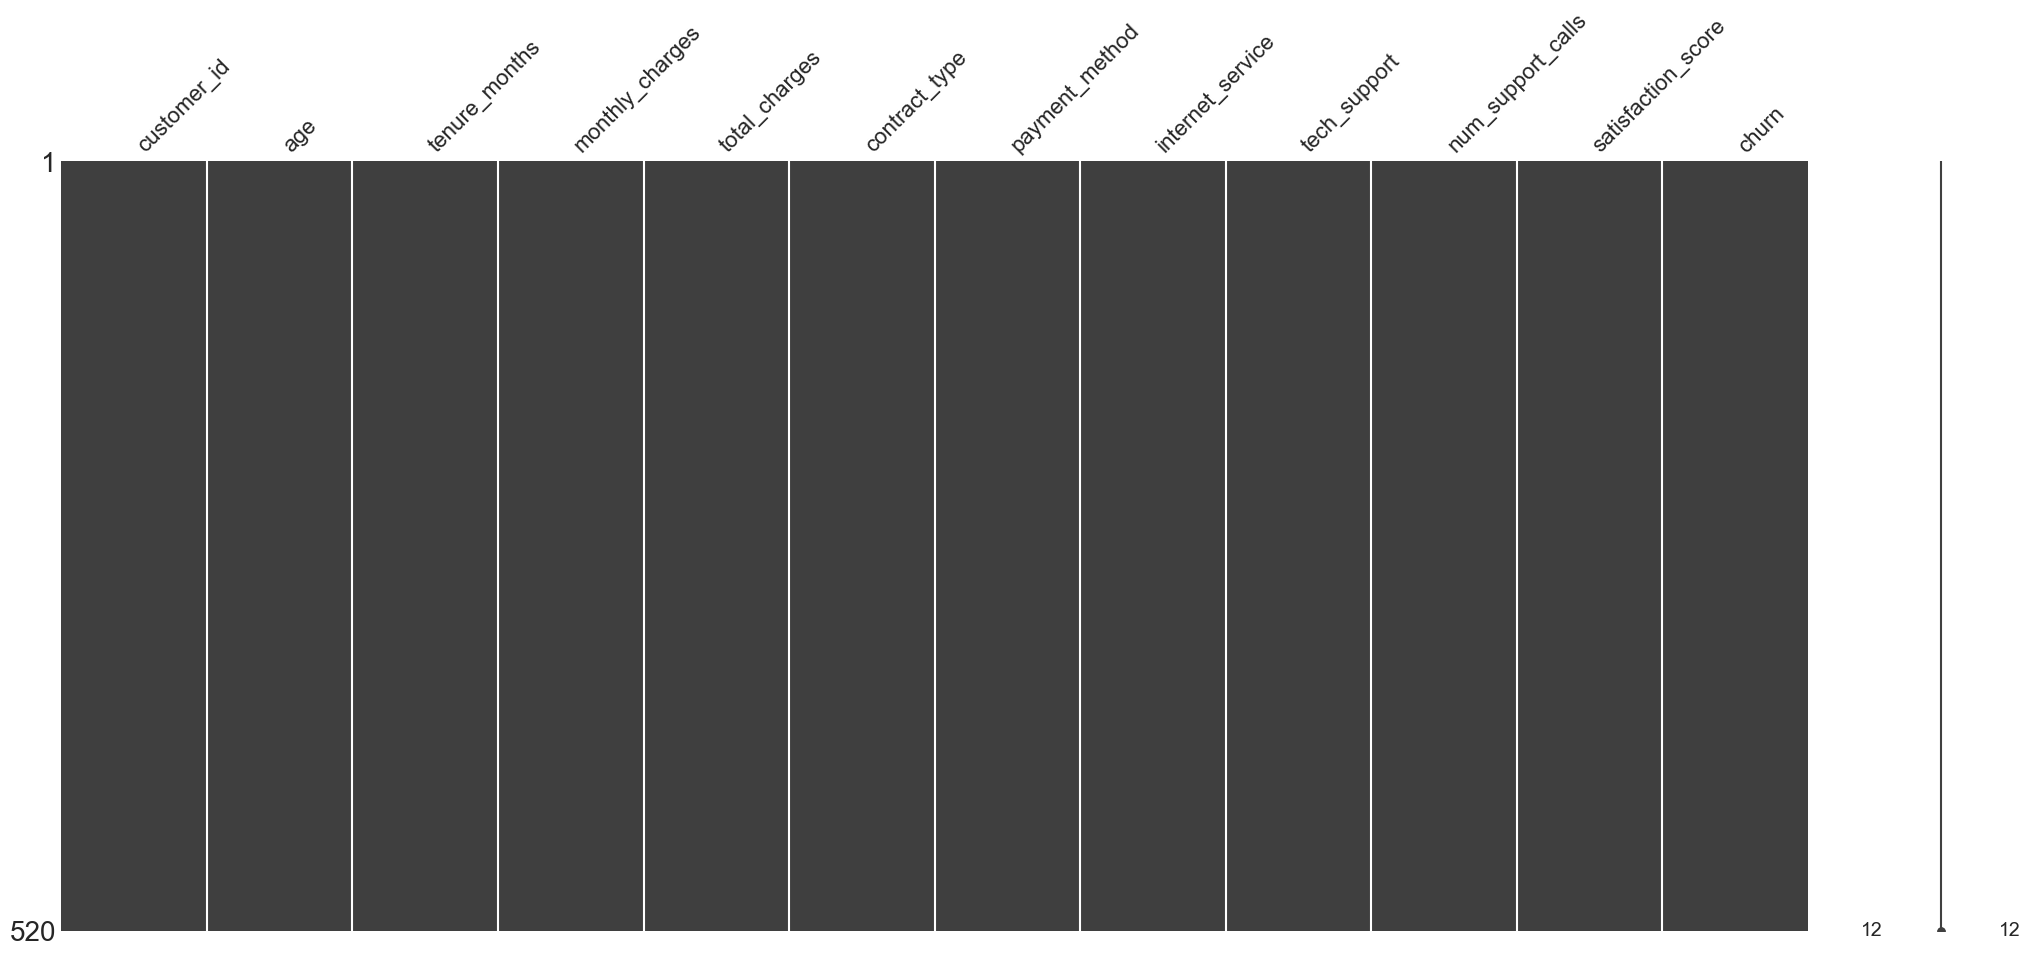

In [17]:
import missingno as msno
msno.matrix(df_mean)

### TODO 6: Impute Categorical Columns with Mode

Use SimpleImputer to fill missing categorical values with the most frequent value.

💡 **Hint:**
```python
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
imputer_mode = SimpleImputer(strategy='most_frequent')
df_mean[categorical_cols] = imputer_mode.fit_transform(df[categorical_cols])
```

In [18]:
# TODO 6: YOUR CODE HERE
# Impute categorical columns with mode

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
imputer_mode = SimpleImputer(strategy='most_frequent')
df_mean[categorical_cols] = imputer_mode.fit_transform(df[categorical_cols])

<Axes: >

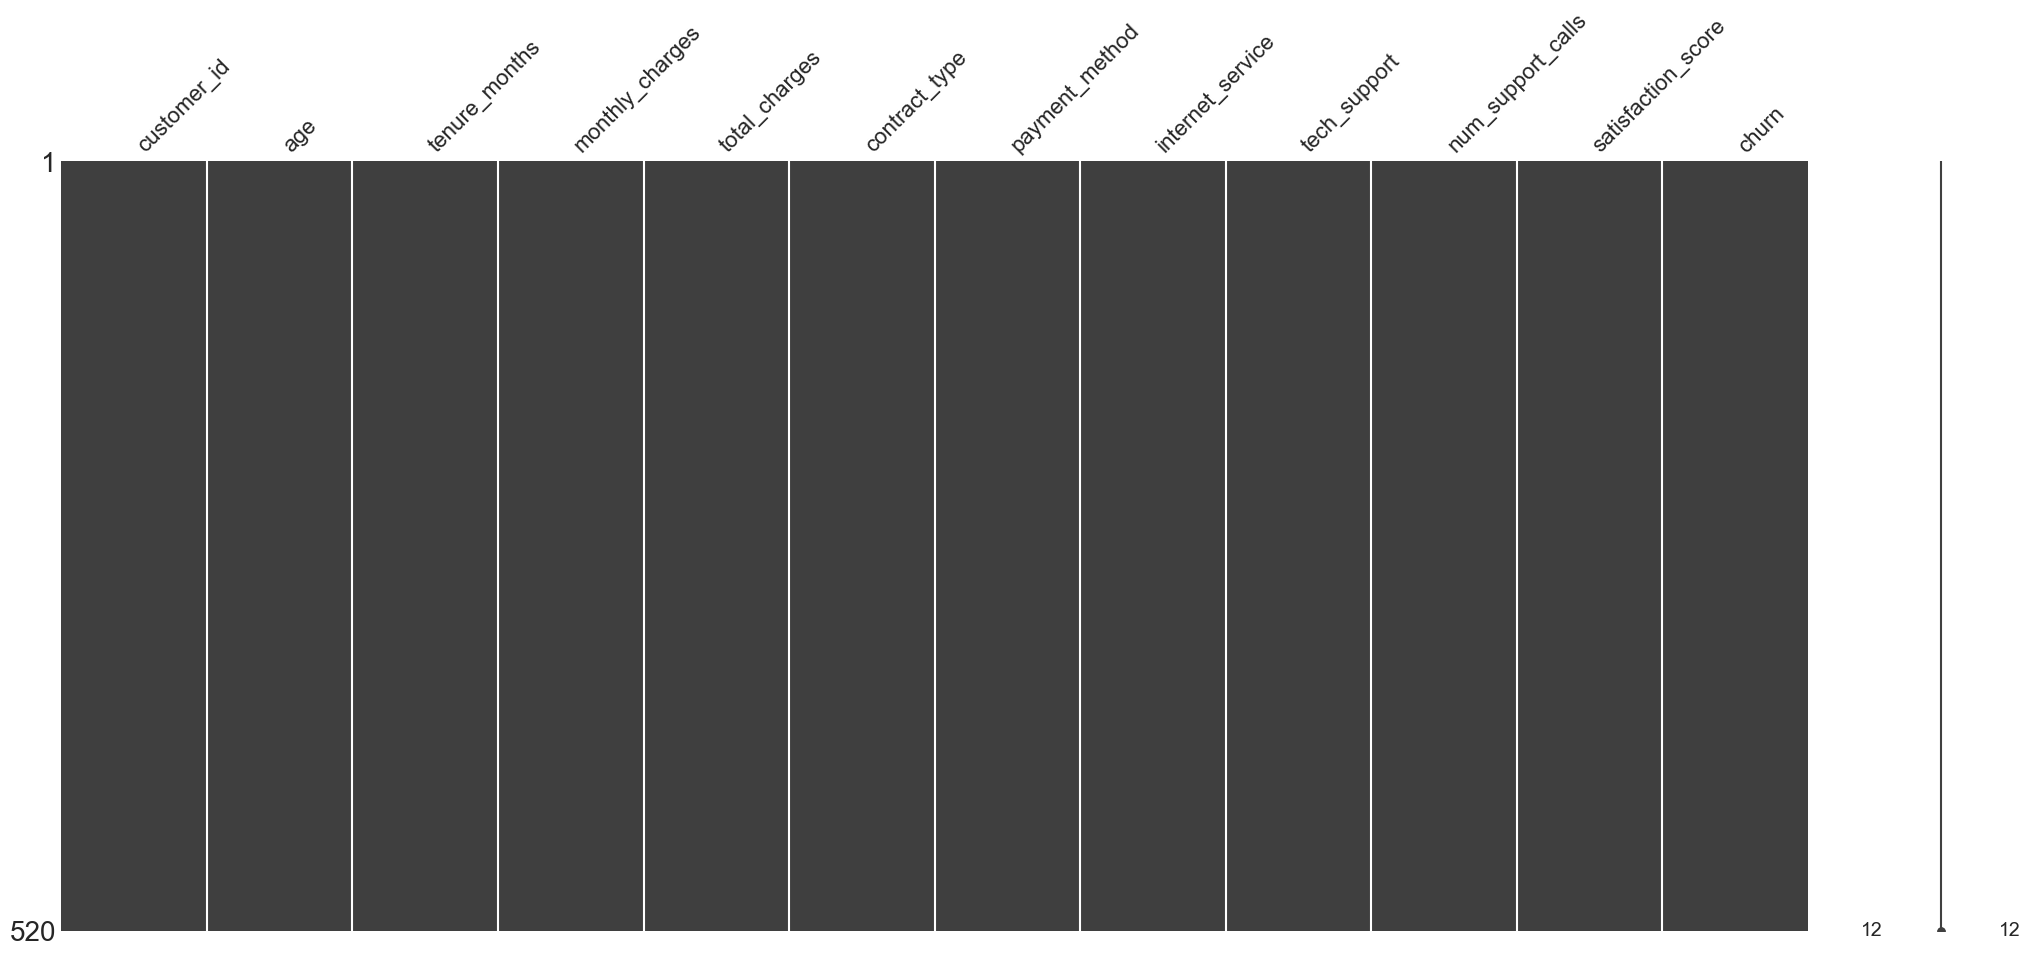

In [19]:
import missingno as msno
msno.matrix(df_mean)

## Step 7: Handle Missing Values - Strategy 3 (KNN Imputation)

### TODO 7: Apply KNN Imputation

Use KNN Imputer for more sophisticated imputation:
1. Use only numerical columns (KNN requires numerical data)
2. Apply KNNImputer with k=5 neighbors
3. Compare with mean imputation


In [20]:
# TODO 7: YOUR CODE HERE
# Apply KNN imputation

from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)
df_knn = df.copy()
df_knn[numerical_cols] = knn_imputer.fit_transform(df[numerical_cols])

## Step 8: Compare Imputation Strategies

### TODO 8: Train Models and Compare Performance

Train a simple RandomForestClassifier on each imputation strategy and compare:
1. Prepare features (drop customer_id, encode categoricals)
2. Train model on each imputed dataset
3. Compare test accuracy



In [21]:
# TODO 8: YOUR CODE HERE
# Compare imputation strategies

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

def evaluate_strategy(df_strategy, name):
    # Prepare data
    df_temp = df_strategy.copy()
    
    # Encode categoricals
    le = LabelEncoder()
    for col in categorical_cols:
        if col in df_temp.columns:
            df_temp[col] = le.fit_transform(df_temp[col].astype(str))
    
    # Split
    X = df_temp.drop(['churn', 'customer_id'], axis=1)
    y = df_temp['churn']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train and evaluate
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    return accuracy

## Step 9: Detect Outliers

### TODO 9: Detect Outliers Using Z-Score Method

Detect outliers in numerical columns using Z-score:
1. Calculate Z-scores for each numerical column
2. Flag values where |Z| > 3
3. Visualize with box plots


In [22]:
# TODO 9: YOUR CODE HERE
# Detect outliers using Z-score
from scipy import stats
z_scores = np.abs(stats.zscore(df_mean[numerical_cols]))
outliers_zscore = (z_scores > 3)


### TODO 10: Detect Outliers Using IQR Method

Detect outliers using Interquartile Range (IQR):
1. Calculate Q1, Q3, and IQR for each column
2. Flag values outside [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
3. Compare with Z-score method

💡 **Hint:**
```python
Q1 = df_mean[numerical_cols].quantile(0.25)
Q3 = df_mean[numerical_cols].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = ((df_mean[numerical_cols] < (Q1 - 1.5 * IQR)) | 
                (df_mean[numerical_cols] > (Q3 + 1.5 * IQR)))
```

In [23]:
# TODO 10: YOUR CODE HERE
# Detect outliers using IQR



## Step 10: Handle Outliers

### TODO 11: Handle Outliers (Cap vs Remove)

Try two approaches:
1. **Capping (Winsorization)**: Replace outliers with boundary values
2. **Removal**: Delete rows with outliers

Compare both approaches!

💡 **Hint:**
```python
# Capping
df_capped = df_mean.copy()
for col in ['monthly_charges', 'num_support_calls']:
    Q1 = df_capped[col].quantile(0.25)
    Q3 = df_capped[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_capped[col] = df_capped[col].clip(lower, upper)
```

In [24]:
# TODO 11: YOUR CODE HERE
# Handle outliers with capping and removal



## Step 11: Remove Duplicates

### TODO 12: Identify and Remove Duplicates

1. Check for duplicate rows
2. Count how many duplicates exist
3. Remove duplicates (keep first occurrence)
4. Verify removal

💡 **Hint:**
```python
duplicates = df_capped.duplicated()
df_no_dups = df_capped.drop_duplicates()
```

In [25]:
# TODO 12: YOUR CODE HERE
# Remove duplicates



## Step 12: Build Complete Cleaning Pipeline

### TODO 13: Create Automated Cleaning Pipeline

Build a reusable function that performs all cleaning steps:
1. Remove duplicates
2. Impute missing values (mean for numerical, mode for categorical)
3. Cap outliers
4. Return cleaned dataframe

💡 **Hint:**
```python
def clean_data(df):
    # Remove duplicates
    df_clean = df.drop_duplicates()
    
    # Impute missing values
    numerical_cols = df_clean.select_dtypes(include=[np.number]).columns
    categorical_cols = df_clean.select_dtypes(include=['object']).columns
    
    # ... implement all steps
    
    return df_clean
```

In [26]:
# TODO 13: YOUR CODE HERE
# Build complete cleaning pipeline



## Step 13: Evaluate Cleaned Data

### TODO 14: Compare Before and After Cleaning

Create a comprehensive comparison:
1. Number of rows (before/after)
2. Missing values (before/after)
3. Outliers (before/after)
4. Distribution plots (before/after)
5. Model performance (before/after)

💡 **Hint:**
```python
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
# Plot distributions before and after for key columns
```

In [27]:
# TODO 14: YOUR CODE HERE
# Compare before and after cleaning



## Congratulations!

### You Did It!

You just:
- ✅ Identified and analyzed missing data patterns
- ✅ Applied multiple imputation strategies
- ✅ Detected outliers using Z-score and IQR methods
- ✅ Handled outliers with capping and removal
- ✅ Removed duplicate rows
- ✅ Built an automated cleaning pipeline
- ✅ Compared cleaning strategies

### What You Learned:
1. **Missing Data Types**: MCAR, MAR, MNAR need different approaches
2. **Imputation Strategies**: Deletion, mean/mode, KNN - each has tradeoffs
3. **Outlier Detection**: Z-score for normal distributions, IQR for any distribution
4. **Outlier Handling**: Capping preserves data, removal loses data
5. **Pipelines**: Automate cleaning for consistent, reproducible results

### Key Insights:
- **Deletion** is simple but loses data (up to 30%!)
- **Mean imputation** is fast but ignores relationships
- **KNN imputation** is sophisticated but slower
- **Capping outliers** usually better than removing them
- **Always remove duplicates** - they inflate your dataset!

### Best Practices:
1. Always explore data before cleaning
2. Understand WHY data is missing
3. Document your cleaning decisions
4. Compare multiple strategies
5. Build reusable pipelines
6. Keep track of data loss

### Next Steps:
- Try Lab 2: Feature Engineering Workshop
- Apply cleaning to your own datasets
- Experiment with other imputation methods (median, forward fill)

---

## Extension Exercises (Optional, Harder!)

1. **Advanced Imputation**: Try MICE (Multiple Imputation by Chained Equations)
2. **Outlier Detection**: Implement Isolation Forest for outlier detection
3. **Feature-Specific**: Create different cleaning strategies per feature type
4. **Validation**: Use cross-validation to select best imputation strategy
5. **Real Data**: Apply to a real dataset from Kaggle

---

## You're a Data Cleaning Expert Now!

**You just mastered real-world data cleaning from scratch!**

**That's AMAZING! Keep cleaning those datasets!**

---
## Solutions (Only Look After Trying!)

Here are the solutions to all TODOs. But remember: **you learn by doing, not by copying!**

In [28]:
# SOLUTION TO TODO 1
print("First 10 rows:")
print(df.head(10))
print("\nDataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())

First 10 rows:
   customer_id   age  tenure_months  monthly_charges  total_charges  \
0          276  51.0            5.0        68.542923     443.981991   
1           94  40.0            NaN        66.298647    2223.147873   
2            7  68.0           16.0       262.139492    2057.109958   
3          168  73.0           42.0        79.097728    1096.180063   
4           91  46.0           24.0        63.209969     642.288790   
5           85  32.0           26.0       223.645159    1843.053200   
6          363  43.0           42.0        67.989509    2134.790976   
7          229  34.0           17.0        89.096978    1793.829851   
8          193   NaN           11.0        49.965809            NaN   
9          483  20.0           12.0              NaN     998.626220   

    contract_type payment_method internet_service         tech_support  \
0  Month-to-month    Credit card               No  No internet service   
1  Month-to-month   Mailed check               No  No i

Missing Values Summary:
                    Missing Count  Percentage
satisfaction_score             50    9.615385
age                            42    8.076923
monthly_charges                39    7.500000
tenure_months                  30    5.769231
total_charges                  26    5.000000


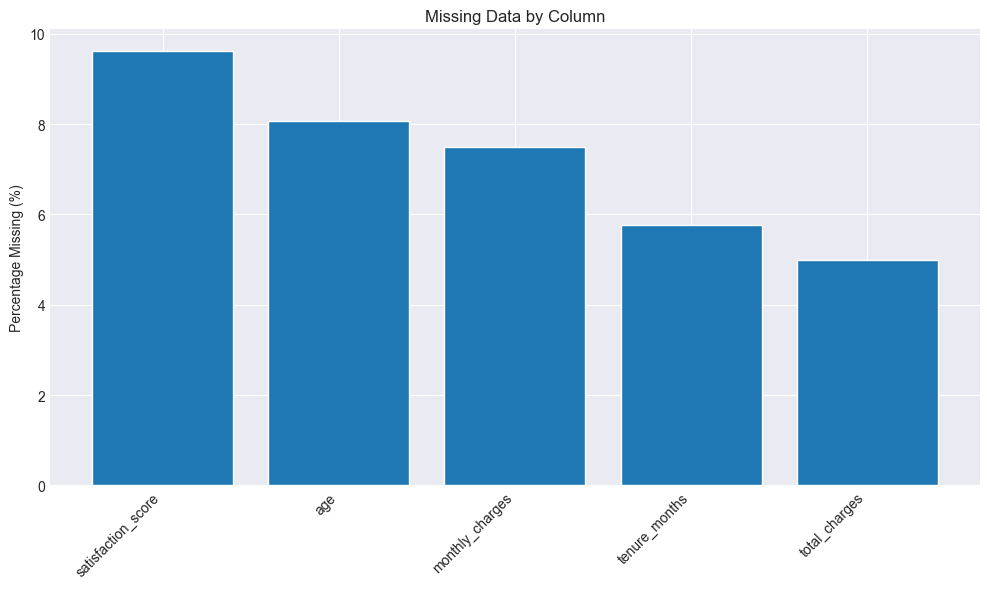

In [29]:
# SOLUTION TO TODO 2
missing = df.isna().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
}).sort_values('Missing Count', ascending=False)

print("Missing Values Summary:")
print(missing_df[missing_df['Missing Count'] > 0])

# Visualize
plt.figure(figsize=(10, 6))
missing_data = missing_df[missing_df['Missing Count'] > 0]
plt.bar(range(len(missing_data)), missing_data['Percentage'])
plt.xticks(range(len(missing_data)), missing_data.index, rotation=45, ha='right')
plt.ylabel('Percentage Missing (%)')
plt.title('Missing Old by Column')
plt.tight_layout()
plt.show()

Missing Data Pattern Analysis:

1. Satisfaction Score Missing vs Churn Rate:
satisfaction_score
False    0.325532
True     1.000000
Name: churn, dtype: float64
Interpretation: Higher churn rate when satisfaction is missing (MAR)

2. Monthly Charges - Missing vs Present:
Average charges when present: $69.07
Interpretation: High-value customers less likely to report (MNAR)


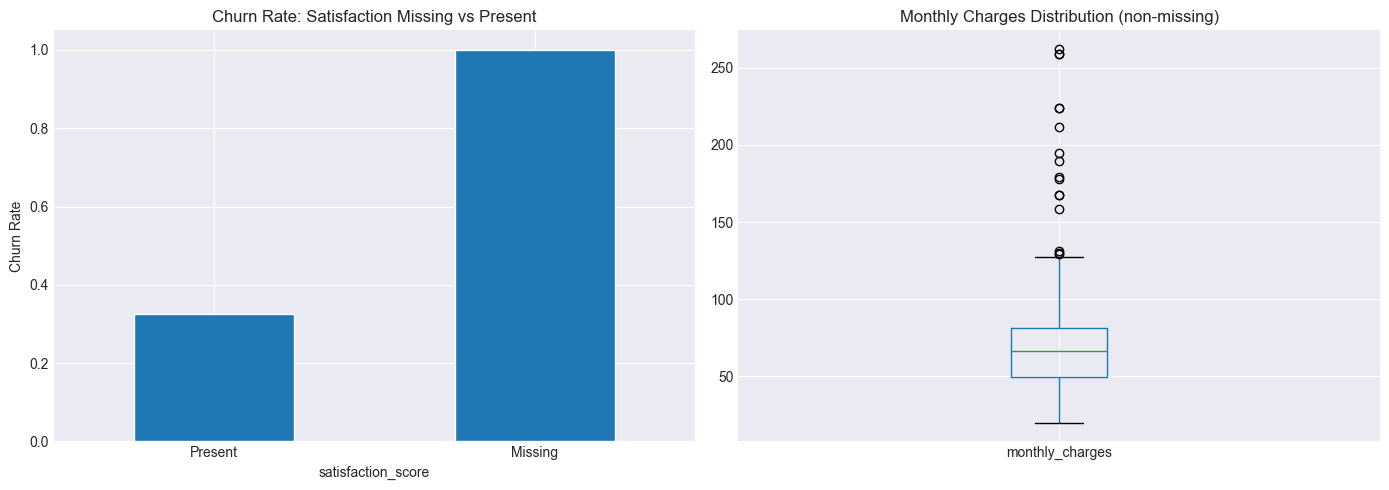

In [30]:
# SOLUTION TO TODO 3
print("Missing Old Pattern Analysis:")
print("="*60)

# Check satisfaction score missingness vs churn (MAR)
missing_satisfaction = df['satisfaction_score'].isna()
print("\n1. Satisfaction Score Missing vs Churn Rate:")
print(df.groupby(missing_satisfaction)['churn'].mean())
print("Interpretation: Higher churn rate when satisfaction is missing (MAR)")

# Check monthly charges missingness (MNAR)
print("\n2. Monthly Charges - Missing vs Present:")
missing_charges = df['monthly_charges'].isna()
print(f"Average charges when present: ${df[~missing_charges]['monthly_charges'].mean():.2f}")
print("Interpretation: High-value customers less likely to report (MNAR)")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
df.groupby(missing_satisfaction)['churn'].mean().plot(kind='bar', ax=axes[0])
axes[0].set_title('Churn Rate: Satisfaction Missing vs Present')
axes[0].set_ylabel('Churn Rate')
axes[0].set_xticklabels(['Present', 'Missing'], rotation=0)

df.boxplot(column='monthly_charges', ax=axes[1])
axes[1].set_title('Monthly Charges Distribution (non-missing)')
plt.tight_layout()
plt.show()

In [31]:
# SOLUTION TO TODO 4
df_deletion = df.dropna()
data_loss = (1 - len(df_deletion) / len(df)) * 100

print("Deletion Strategy Results:")
print("="*60)
print(f"Original rows: {len(df)}")
print(f"Rows after deletion: {len(df_deletion)}")
print(f"Rows lost: {len(df) - len(df_deletion)} ({data_loss:.1f}%)")
print(f"\n⚠️ WARNING: Lost {data_loss:.1f}% of data!")
print(f"This is typically TOO MUCH data loss.")

Deletion Strategy Results:
Original rows: 520
Rows after deletion: 361
Rows lost: 159 (30.6%)

⚠️ WARNING: Lost 30.6% of data!
This is typically TOO MUCH data loss.


In [32]:
# SOLUTION TO TODO 5
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Remove target and ID from imputation
numerical_cols = [col for col in numerical_cols if col not in ['churn', 'customer_id']]

imputer_mean = SimpleImputer(strategy='mean')
df_mean = df.copy()
df_mean[numerical_cols] = imputer_mean.fit_transform(df[numerical_cols])

print("Mean Imputation Results:")
print("="*60)
print(f"Numerical columns imputed: {numerical_cols}")
print(f"Missing values remaining in numerical: {df_mean[numerical_cols].isna().sum().sum()}")
print("✅ All numerical missing values filled with column means!")

Mean Imputation Results:
Numerical columns imputed: ['age', 'tenure_months', 'monthly_charges', 'total_charges', 'num_support_calls', 'satisfaction_score']
Missing values remaining in numerical: 0
✅ All numerical missing values filled with column means!


In [33]:
# SOLUTION TO TODO 6
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
imputer_mode = SimpleImputer(strategy='most_frequent')
df_mean[categorical_cols] = imputer_mode.fit_transform(df[categorical_cols])

print("Mode Imputation Results:")
print("="*60)
print(f"Categorical columns imputed: {categorical_cols}")
print(f"Missing values remaining in categorical: {df_mean[categorical_cols].isna().sum().sum()}")
print(f"Total missing values remaining: {df_mean.isna().sum().sum()}")
print("✅ All missing values filled!")

Mode Imputation Results:
Categorical columns imputed: ['contract_type', 'payment_method', 'internet_service', 'tech_support']
Missing values remaining in categorical: 0
Total missing values remaining: 0
✅ All missing values filled!


In [34]:
# SOLUTION TO TODO 7
knn_imputer = KNNImputer(n_neighbors=5)
df_knn = df.copy()
df_knn[numerical_cols] = knn_imputer.fit_transform(df[numerical_cols])
# Still need mode for categorical
df_knn[categorical_cols] = imputer_mode.fit_transform(df[categorical_cols])

print("KNN Imputation Results:")
print("="*60)
print(f"Missing values remaining: {df_knn.isna().sum().sum()}")
print("✅ KNN imputation complete!")

# Compare a few values
print("\nComparison: Mean vs KNN Imputation")
print("First 5 imputed 'age' values:")
comparison_df = pd.DataFrame({
    'Original': df['age'].head(),
    'Mean': df_mean['age'].head(),
    'KNN': df_knn['age'].head()
})
print(comparison_df)

KNN Imputation Results:
Missing values remaining: 0
✅ KNN imputation complete!

Comparison: Mean vs KNN Imputation
First 5 imputed 'age' values:
   Original  Mean   KNN
0      51.0  51.0  51.0
1      40.0  40.0  40.0
2      68.0  68.0  68.0
3      73.0  73.0  73.0
4      46.0  46.0  46.0


Imputation Strategy Comparison:
Deletion       : Accuracy=0.6986, Training samples=288
Mean/Mode      : Accuracy=0.6635, Training samples=416
KNN            : Accuracy=0.5769, Training samples=416


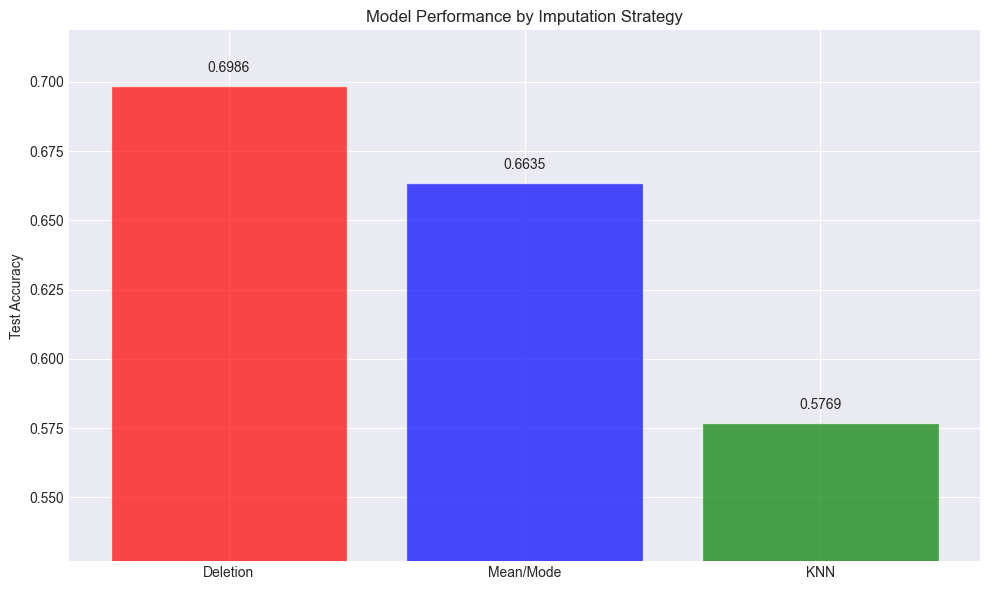

In [35]:
# SOLUTION TO TODO 8
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

def evaluate_strategy(df_strategy, name):
    """Evaluate imputation strategy by training a model"""
    df_temp = df_strategy.copy()
    
    # Encode categoricals
    le = LabelEncoder()
    for col in categorical_cols:
        if col in df_temp.columns:
            df_temp[col] = le.fit_transform(df_temp[col].astype(str))
    
    # Prepare features and target
    X = df_temp.drop(['churn', 'customer_id'], axis=1)
    y = df_temp['churn']
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train and evaluate
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    
    return accuracy, len(X_train)

# Compare strategies
results = {}
results['Deletion'] = evaluate_strategy(df_deletion, 'Deletion')
results['Mean/Mode'] = evaluate_strategy(df_mean, 'Mean/Mode')
results['KNN'] = evaluate_strategy(df_knn, 'KNN')

print("Imputation Strategy Comparison:")
print("="*60)
for strategy, (acc, n_samples) in results.items():
    print(f"{strategy:15s}: Accuracy={acc:.4f}, Training samples={n_samples}")

# Visualize
strategies = list(results.keys())
accuracies = [results[s][0] for s in strategies]

plt.figure(figsize=(10, 6))
plt.bar(strategies, accuracies, color=['red', 'blue', 'green'], alpha=0.7)
plt.ylabel('Test Accuracy')
plt.title('Model Performance by Imputation Strategy')
plt.ylim([min(accuracies)-0.05, max(accuracies)+0.02])
for i, acc in enumerate(accuracies):
    plt.text(i, acc+0.005, f'{acc:.4f}', ha='center')
plt.tight_layout()
plt.show()

Z-Score Outlier Detection (|Z| > 3):
monthly_charges          :  12 outliers (2.3%)
total_charges            :   1 outliers (0.2%)
num_support_calls        :  10 outliers (1.9%)


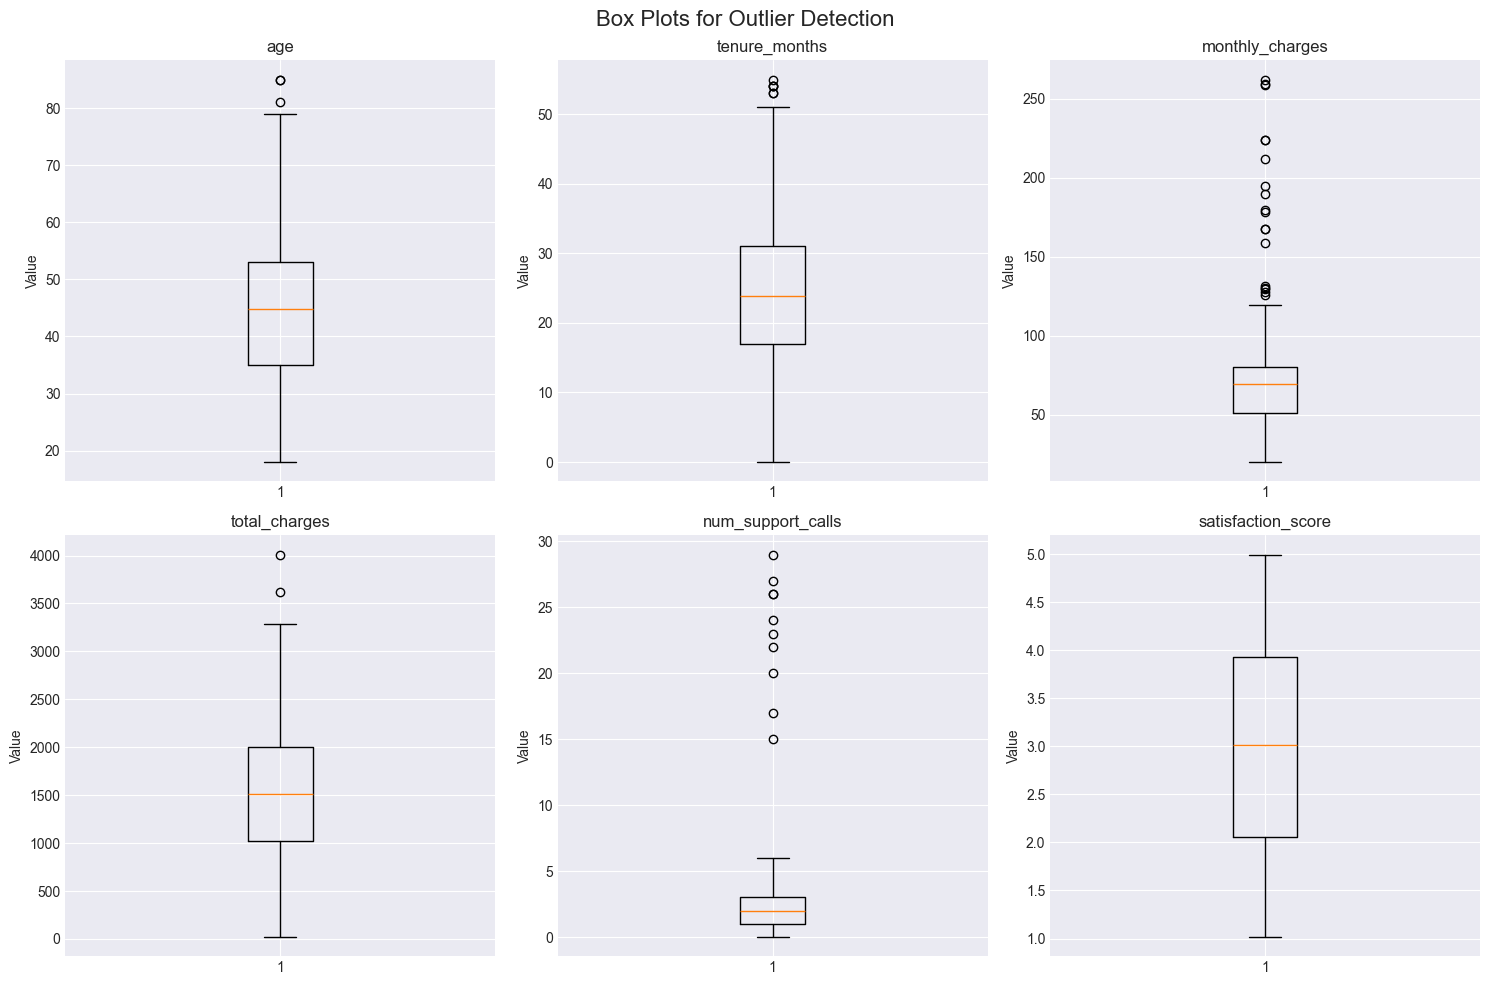

In [36]:
# SOLUTION TO TODO 9
from scipy import stats

# Calculate Z-scores
z_scores = np.abs(stats.zscore(df_mean[numerical_cols], nan_policy='omit'))
outliers_zscore = (z_scores > 3)

print("Z-Score Outlier Detection (|Z| > 3):")
print("="*60)
for col in numerical_cols:
    col_idx = numerical_cols.index(col)
    n_outliers = outliers_zscore[:, col_idx].sum()
    if n_outliers > 0:
        print(f"{col:25s}: {n_outliers:3d} outliers ({n_outliers/len(df_mean)*100:.1f}%)")

# Visualize with box plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()
for idx, col in enumerate(numerical_cols[:6]):
    axes[idx].boxplot(df_mean[col].dropna())
    axes[idx].set_title(f'{col}')
    axes[idx].set_ylabel('Value')
plt.suptitle('Box Plots for Outlier Detection', fontsize=16)
plt.tight_layout()
plt.show()

In [37]:
# SOLUTION TO TODO 10
Q1 = df_mean[numerical_cols].quantile(0.25)
Q3 = df_mean[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

outliers_iqr = ((df_mean[numerical_cols] < (Q1 - 1.5 * IQR)) | 
                (df_mean[numerical_cols] > (Q3 + 1.5 * IQR)))

print("IQR Outlier Detection (Q1 - 1.5*IQR, Q3 + 1.5*IQR):")
print("="*60)
for col in numerical_cols:
    n_outliers = outliers_iqr[col].sum()
    if n_outliers > 0:
        print(f"{col:25s}: {n_outliers:3d} outliers ({n_outliers/len(df_mean)*100:.1f}%)")

print("\nComparison: Z-Score vs IQR")
print("="*60)
for idx, col in enumerate(numerical_cols):
    z_count = outliers_zscore[:, idx].sum()
    iqr_count = outliers_iqr[col].sum()
    if z_count > 0 or iqr_count > 0:
        print(f"{col:25s}: Z-score={z_count:3d}, IQR={iqr_count:3d}")

IQR Outlier Detection (Q1 - 1.5*IQR, Q3 + 1.5*IQR):
age                      :   3 outliers (0.6%)
tenure_months            :   6 outliers (1.2%)
monthly_charges          :  18 outliers (3.5%)
total_charges            :   2 outliers (0.4%)
num_support_calls        :  10 outliers (1.9%)

Comparison: Z-Score vs IQR
age                      : Z-score=  0, IQR=  3
tenure_months            : Z-score=  0, IQR=  6
monthly_charges          : Z-score= 12, IQR= 18
total_charges            : Z-score=  1, IQR=  2
num_support_calls        : Z-score= 10, IQR= 10


age: Capped 3 outliers to [8.00, 80.00]
tenure_months: Capped 6 outliers to [-4.00, 52.00]
monthly_charges: Capped 18 outliers to [7.26, 123.46]
total_charges: Capped 2 outliers to [-443.26, 3464.52]
num_support_calls: Capped 10 outliers to [-2.00, 6.00]

✅ Capping complete! Rows: 520 (no data lost)

⚠️ Removal complete! Rows: 482 (lost 7.3%)


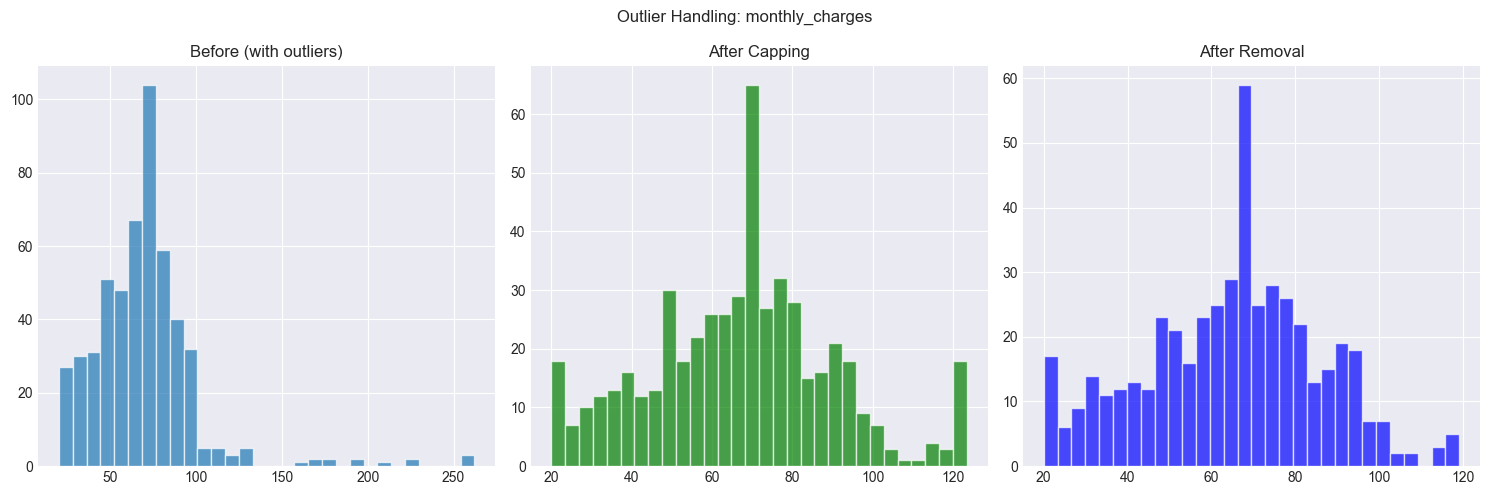

In [38]:
# SOLUTION TO TODO 11
# Strategy 1: Capping (Winsorization)
df_capped = df_mean.copy()
for col in numerical_cols:
    Q1 = df_capped[col].quantile(0.25)
    Q3 = df_capped[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    # Count outliers before capping
    n_outliers = ((df_capped[col] < lower) | (df_capped[col] > upper)).sum()
    
    # Cap
    df_capped[col] = df_capped[col].clip(lower, upper)
    
    if n_outliers > 0:
        print(f"{col}: Capped {n_outliers} outliers to [{lower:.2f}, {upper:.2f}]")

print(f"\n✅ Capping complete! Rows: {len(df_capped)} (no data lost)")

# Strategy 2: Removal
df_removed = df_mean.copy()
for col in numerical_cols:
    Q1 = df_removed[col].quantile(0.25)
    Q3 = df_removed[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_removed = df_removed[(df_removed[col] >= lower) & (df_removed[col] <= upper)]

data_loss = (1 - len(df_removed) / len(df_mean)) * 100
print(f"\n⚠️ Removal complete! Rows: {len(df_removed)} (lost {data_loss:.1f}%)")

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
test_col = 'monthly_charges'
axes[0].hist(df_mean[test_col], bins=30, alpha=0.7)
axes[0].set_title('Before (with outliers)')
axes[1].hist(df_capped[test_col], bins=30, alpha=0.7, color='green')
axes[1].set_title('After Capping')
axes[2].hist(df_removed[test_col], bins=30, alpha=0.7, color='blue')
axes[2].set_title('After Removal')
plt.suptitle(f'Outlier Handling: {test_col}')
plt.tight_layout()
plt.show()

In [39]:
# SOLUTION TO TODO 12
print("Duplicate Detection:")
print("="*60)
duplicates = df_capped.duplicated()
n_duplicates = duplicates.sum()
print(f"Number of duplicate rows: {n_duplicates}")
print(f"Percentage: {n_duplicates/len(df_capped)*100:.1f}%")

# Show a few duplicates
if n_duplicates > 0:
    print("\nExample duplicate rows:")
    dup_indices = df_capped[duplicates].index[:3]
    for idx in dup_indices:
        print(f"\nDuplicate at index {idx}:")
        print(df_capped.loc[idx])

# Remove duplicates
df_no_dups = df_capped.drop_duplicates()

print(f"\n✅ Duplicates removed!")
print(f"Before: {len(df_capped)} rows")
print(f"After: {len(df_no_dups)} rows")
print(f"Removed: {len(df_capped) - len(df_no_dups)} duplicate rows")

Duplicate Detection:
Number of duplicate rows: 20
Percentage: 3.8%

Example duplicate rows:

Duplicate at index 21:
customer_id                       85
age                             32.0
tenure_months                   26.0
monthly_charges           123.461387
total_charges              1843.0532
contract_type         Month-to-month
payment_method          Mailed check
internet_service                 DSL
tech_support                      No
num_support_calls                0.0
satisfaction_score           3.70728
churn                              0
Name: 21, dtype: object

Duplicate at index 35:
customer_id                         69
age                               50.0
tenure_months                      1.0
monthly_charges               53.30747
total_charges               249.963314
contract_type           Month-to-month
payment_method        Electronic check
internet_service                   DSL
tech_support                        No
num_support_calls                  1.0
sa

In [40]:
# SOLUTION TO TODO 13
def clean_data(df):
    """
    Complete data cleaning pipeline
    
    Steps:
    1. Remove duplicates
    2. Impute missing values (mean for numerical, mode for categorical)
    3. Cap outliers using IQR method
    4. Return cleaned dataframe
    """
    print("Starting cleaning pipeline...")
    df_clean = df.copy()
    
    # Step 1: Remove duplicates
    n_before_dup = len(df_clean)
    df_clean = df_clean.drop_duplicates()
    n_after_dup = len(df_clean)
    print(f"✓ Removed {n_before_dup - n_after_dup} duplicates")
    
    # Step 2: Impute missing values
    numerical_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
    numerical_cols = [col for col in numerical_cols if col not in ['churn', 'customer_id']]
    categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
    
    # Numerical: mean
    imputer_mean = SimpleImputer(strategy='mean')
    df_clean[numerical_cols] = imputer_mean.fit_transform(df_clean[numerical_cols])
    
    # Categorical: mode
    imputer_mode = SimpleImputer(strategy='most_frequent')
    df_clean[categorical_cols] = imputer_mode.fit_transform(df_clean[categorical_cols])
    print(f"✓ Imputed missing values (mean for numerical, mode for categorical)")
    
    # Step 3: Cap outliers
    n_capped = 0
    for col in numerical_cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        
        n_outliers = ((df_clean[col] < lower) | (df_clean[col] > upper)).sum()
        n_capped += n_outliers
        df_clean[col] = df_clean[col].clip(lower, upper)
    
    print(f"✓ Capped {n_capped} outlier values")
    print(f"\n✅ Cleaning complete! Final rows: {len(df_clean)}")
    
    return df_clean

# Test the pipeline on original messy data
df_final = clean_data(df)

print("\nFinal Old Quality:")
print("="*60)
print(f"Rows: {len(df_final)}")
print(f"Missing values: {df_final.isna().sum().sum()}")
print(f"Duplicates: {df_final.duplicated().sum()}")

Starting cleaning pipeline...
✓ Removed 20 duplicates
✓ Imputed missing values (mean for numerical, mode for categorical)
✓ Capped 37 outlier values

✅ Cleaning complete! Final rows: 500

Final Data Quality:
Rows: 500
Missing values: 0
Duplicates: 0


BEFORE vs AFTER CLEANING COMPARISON

1. Data Volume:
   Before: 520 rows
   After:  500 rows
   Lost:   20 rows (3.8%)

2. Missing Values:
   Before: 187 missing values
   After:  0 missing values

3. Duplicates:
   Before: 20 duplicates
   After:  0 duplicates

4. Outliers (in monthly_charges):
   Before: 16 outliers
   After:  0 outliers


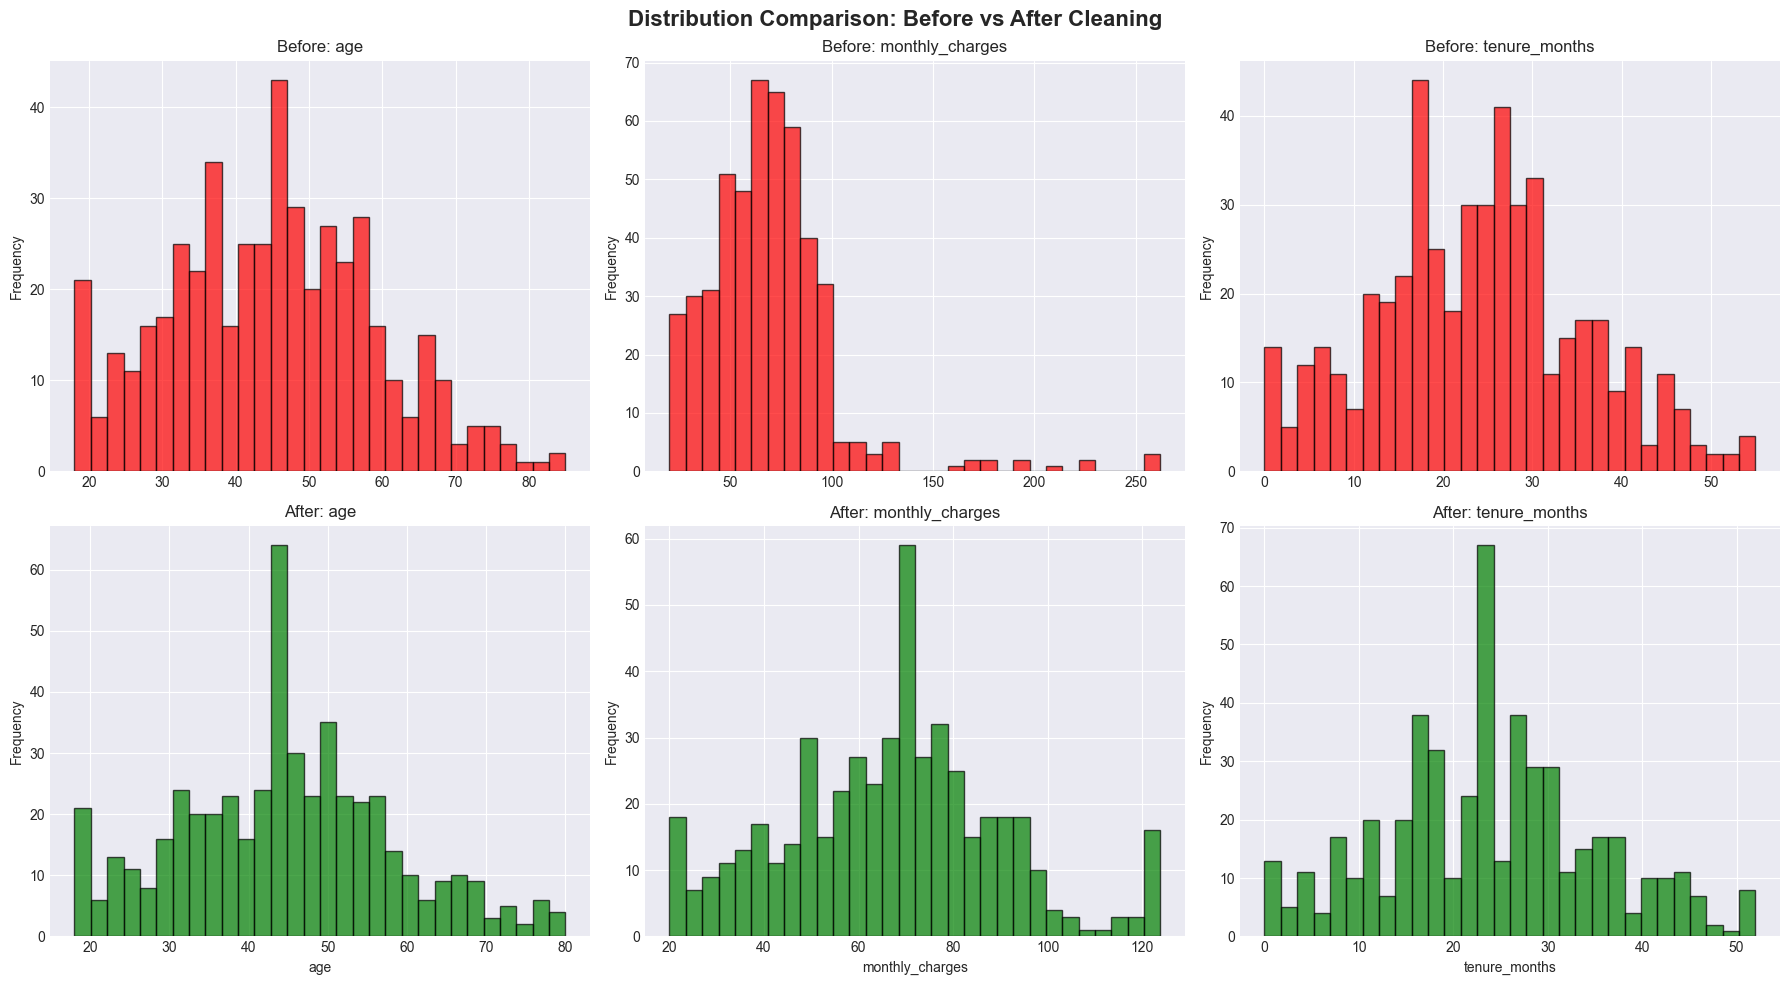


5. Model Performance:
   Comparing churn prediction accuracy...
   Before cleaning: 0.6986
   After cleaning:  0.7100
   Improvement:     +1.14%

✅ Data cleaning improved quality and potentially model performance!


In [41]:
# SOLUTION TO TODO 14
print("BEFORE vs AFTER CLEANING COMPARISON")
print("="*80)

# 1. Row count
print(f"\n1. Old Volume:")
print(f"   Before: {len(df)} rows")
print(f"   After:  {len(df_final)} rows")
print(f"   Lost:   {len(df) - len(df_final)} rows ({(1-len(df_final)/len(df))*100:.1f}%)")

# 2. Missing values
print(f"\n2. Missing Values:")
print(f"   Before: {df.isna().sum().sum()} missing values")
print(f"   After:  {df_final.isna().sum().sum()} missing values")

# 3. Duplicates
print(f"\n3. Duplicates:")
print(f"   Before: {df.duplicated().sum()} duplicates")
print(f"   After:  {df_final.duplicated().sum()} duplicates")

# 4. Outliers
print(f"\n4. Outliers (in monthly_charges):")
Q1_before = df['monthly_charges'].quantile(0.25)
Q3_before = df['monthly_charges'].quantile(0.75)
IQR_before = Q3_before - Q1_before
outliers_before = ((df['monthly_charges'] < (Q1_before - 1.5*IQR_before)) | 
                   (df['monthly_charges'] > (Q3_before + 1.5*IQR_before))).sum()

Q1_after = df_final['monthly_charges'].quantile(0.25)
Q3_after = df_final['monthly_charges'].quantile(0.75)
IQR_after = Q3_after - Q1_after
outliers_after = ((df_final['monthly_charges'] < (Q1_after - 1.5*IQR_after)) | 
                  (df_final['monthly_charges'] > (Q3_after + 1.5*IQR_after))).sum()

print(f"   Before: {outliers_before} outliers")
print(f"   After:  {outliers_after} outliers")

# 5. Visualize distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

cols_to_plot = ['age', 'monthly_charges', 'tenure_months']
for idx, col in enumerate(cols_to_plot):
    # Before
    axes[0, idx].hist(df[col].dropna(), bins=30, alpha=0.7, color='red', edgecolor='black')
    axes[0, idx].set_title(f'Before: {col}')
    axes[0, idx].set_ylabel('Frequency')
    
    # After
    axes[1, idx].hist(df_final[col], bins=30, alpha=0.7, color='green', edgecolor='black')
    axes[1, idx].set_title(f'After: {col}')
    axes[1, idx].set_ylabel('Frequency')
    axes[1, idx].set_xlabel(col)

plt.suptitle('Distribution Comparison: Before vs After Cleaning', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# 6. Model performance comparison
print(f"\n5. Model Performance:")
print("   Comparing churn prediction accuracy...")

from sklearn.preprocessing import LabelEncoder

def quick_model_eval(data, name):
    df_temp = data.copy().dropna()  # Remove any remaining NaN
    
    # Encode categoricals
    le = LabelEncoder()
    cat_cols = df_temp.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df_temp[col] = le.fit_transform(df_temp[col].astype(str))
    
    X = df_temp.drop(['churn', 'customer_id'], axis=1)
    y = df_temp['churn']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    return acc

acc_before = quick_model_eval(df, "Before")
acc_after = quick_model_eval(df_final, "After")

print(f"   Before cleaning: {acc_before:.4f}")
print(f"   After cleaning:  {acc_after:.4f}")
print(f"   Improvement:     {(acc_after-acc_before)*100:+.2f}%")

print("\n" + "="*80)
print("✅ Old cleaning improved quality and potentially model performance!")
print("="*80)